### Conditional density estimation

This example shows how we can perform conditional density estimation with normalising flows.
Here we use a [block_neural_autoregressive_flow](../api/flows.rst#flowjax.flows.block_neural_autoregressive_flow),
although other flows are available and all support conditional density estimation (see [flowjax.flows](../api/flows.rst)). We consider a two dimensional model, where the upper limit of the target uniform distribution depends on another uniform random variable:
$$u_i \sim \text{Uniform}(0,5) \quad \text{for}\ i\ \text{in}\ 1,2$$
$$x_i \sim \text{Uniform}(0, u_i), \quad \text{for}\ i\ \text{in}\ 1,2$$

We will try to infer the conditional distribution $p(x|u)$ using samples from the model.


Importing the required libraries.

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from flowjax.distributions import Normal
from flowjax.flows import block_neural_autoregressive_flow
from flowjax.train import fit_to_data

Generating the toy data.

In [2]:
key, x_key, cond_key = jr.split(jr.PRNGKey(0), 3)
u = jr.uniform(cond_key, (10000, 2), minval=0, maxval=5)
x = jr.uniform(x_key, shape=u.shape, maxval=u)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Creating and training the flow.

In [3]:
key, subkey = jr.split(jr.PRNGKey(0))

flow = block_neural_autoregressive_flow(
    key=subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    cond_dim=u.shape[1],
)

key, subkey = jr.split(key)
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=x,
    condition=u,
    learning_rate=5e-3,
    max_patience=10,
)

 46%|████▌     | 46/100 [00:10<00:12,  4.20it/s, train=1.2797738, val=1.3016225 (Max patience reached)]


We can now visualise the learned density. Let's condition on $u=[1,3]'$, in which case we expect $x_1 \sim \text{Uniform}(0, 1)$ and $x_2 \sim \text{Uniform}(0, 3)$

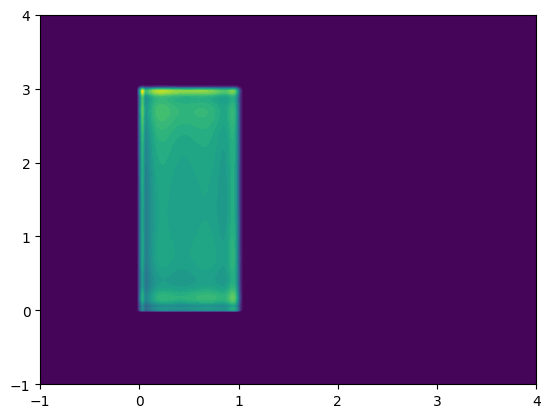

In [4]:
resolution = 200
test_u = jnp.array([1.0, 3])

xgrid, ygrid = jnp.meshgrid(
    jnp.linspace(-1, 4, resolution), jnp.linspace(-1, 4, resolution),
)
xyinput = jnp.column_stack((xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)))
zgrid = jnp.exp(flow.log_prob(xyinput, test_u).reshape(resolution, resolution))
plt.contourf(xgrid, ygrid, zgrid, levels=50)
plt.show()